In [1]:
import re
import time
import os
import datetime
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
import numpy as np
# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

## Read URL's from .csv

In [2]:
data = pd.read_csv('../data/vehicle_data/auction_data.csv')
data_paint = pd.read_csv('../data/vehicle_data/bat_intermediate_data.csv').paint_str
data['color'] = data_paint

data.head(2)

,Auction Date,Make,Model,Year,Kilometers,Miles,Mileage Notes,Sale_Status,Final Bid Price,VIN,Details,URL,color
0,3/16/22,ACOMA,Era1970s,1975,1200.0,745.0,"2k Kilometers (~1,200 miles) Shown, TMU",Sold,10100.0,7202,"Chassis: 7202 ,2k Kilometers (~1,200 miles) Sh...",https://bringatrailer.com/listing/1975-acoma-m...,white
1,12/10/20,ACOMA,Era1970s,1975,1200.0,745.0,"2k Kilometers (~1,200 Miles) Shown",Sold,8000.0,7202ECON,"Chassis: 7202ECON ,2k Kilometers (~1,200 Miles...",https://bringatrailer.com/listing/1975-acoma-m...,white


## Massaging Data

In [3]:
# convert everything lowercase for readability
data['Make'] = data['Make'].str.lower()
data['Model'] = data['Model'].str.lower()

# Remove year outliers
print('Removed', len(data[data['Year'] > 2023]) + len(data[data.Year < 1900]), 'year outliers')
data = data[data.Year < 2023]
data = data[data.Year > 1900]

# Remove miles outliers
print('Removed', len(data[data.Miles > 300000]), 'mileage outliers')
data = data[data.Miles < 300000]

# Remove 'erasXXXX' or 'origin' in Makes as they are useless
make_rem_lst = list(set([make for make in data.Make if 'era1' in make or 'era2' in make or 'origin' in make]))
data = data[~data.Make.isin(make_rem_lst)]

# Remove 'erasXXXX' or 'origin' in Makes as they are useless
model_rem_lst = list(set([model for model in data.Model if 'era1' in model or 'era2' in model or 'origin' in model]))
data = data[~data.Model.isin(model_rem_lst)]

# Remove any vehicles where sale_status is 0 as these did not sell
data = data[data.Sale_Status == 'Sold']

# Drop useless/redundent cols
data.drop(['Sale_Status', 'VIN', 'Kilometers', 'URL'], inplace=True, axis=1)

Removed 118 year outliers
Removed 141 mileage outliers


## Convert dates into separate features

In [4]:
year, month = [], []
# time_lst = ['year', 'month', 'day']
t_format = "%m/%d/%y"

for time in data["Auction Date"]:
    year.append(datetime.datetime.strptime(time, t_format).year)
    month.append(datetime.datetime.strptime(time, t_format).month)

data['auction_year'] = year
# data['auction_month'] = month

data.drop("Auction Date", inplace=True, axis=1)

## Exploring Details Column

In [5]:
# data.Details

## Extracting Engine Size and # Cylinders

In [6]:
## Exploring Details
details_df = data.Details

# Drop 'Chassis' VIN info
details_df = details_df.str.split(',', expand=True, n=1)
details_df = details_df.drop(0, axis=1)

# Rename column
details_df.columns = ['details']

# Split the remaining details data
details_df.details = details_df.details.str.split(',', expand=False)
details_df.columns = ['details']

# details_df.details = details_df.details.str.lower()
# Extract engine size from details
eng_keywords = ["liter", "v6", "v8", "engine", "inline", "three", "four", "five", "six", "eight", "ci", "cc", "flathead", "cylinder", "dohc", "sohc", "ohc", "turbocharged"]
eng_detail_lst = []

for details in details_df.details:
    match = False
    for detail in details:
        detail=detail.lower()
        if any(word in detail for word in eng_keywords):
            match = True
            eng_detail_lst.append(detail)
            # print(detail)
            break
    if not match:
        # print(np.nan)
        eng_detail_lst.append(np.nan)
        

print('Lengths of df and eng-size are the same:', len(eng_detail_lst) == len(details_df), len(eng_detail_lst))
eng_detail_lst.count(np.nan)

Lengths of df and eng-size are the same: True 53386


846

In [7]:
data.reset_index(drop=True, inplace=True)
data[data.Model == "nc mx-5 miata"].Details.index
eng_detail_lst[31219]
# data.Details.iloc[31219]
data.head()

,Make,Model,Year,Miles,Mileage Notes,Final Bid Price,Details,color,auction_year
0,acura,integra,1997,52000.0,52k Miles Shown,26500.0,"Chassis: JH4DC2390VS002243 ,52k Miles Shown ,1...",green,2022
1,acura,integra,1995,72000.0,72k Miles Shown,7100.0,"Chassis: JH4DB766XSS007382 ,72k Miles Shown ,1...",black,2022
2,acura,integra,1995,43000.0,43k Miles Shown,8900.0,"Chassis: JH4DC4468SS017309 ,43k Miles Shown ,1...",white,2022
3,acura,integra,1994,47000.0,47k Miles Shown,11800.0,"Chassis: JH4DC4341RS007683 ,47k Miles Shown ,1...",NaN,2022
4,acura,integra,2000,35000.0,35k Miles Shown,15500.0,"Chassis: JH4DC4456YS011332 ,35k Miles Shown ,1...",silver,2022


### Engine Size
- The engine_detail_lst contains sizes of engine in liters and sometimes cubic inches or centimeters
- It also contains # of cylinders
- We need to extract the size of engine as well as # of cylinders

In [8]:
'''
Getting list of engine sizes as strings!
'''
eng_size_keywords = ["liter", "ci", "cc"]
eng_size_re_lst = ["[0-9]+.[0-9]+", "[0-9]+.[0-9]+l"]
eng_size_lst = []

# Extract engine size details
for sentence in eng_detail_lst[:]:
    if pd.isna(sentence):
        eng_size_lst.append(np.nan)
        continue
    match = False
    words = sentence.split(" ")
    for word in words:
        if len(re.findall(eng_size_re_lst[0], word)) > 0 or len(re.findall(eng_size_re_lst[1], word)) > 0:
            eng_size_lst.append(word)
            match = True
            break
        elif any(w in word for w in eng_size_keywords):
            eng_size_lst.append(word)
            match = True
            break
    
    if not match:
        # print(words)
        eng_size_lst.append(np.nan)


print(eng_size_lst.count(np.nan), 'instances of NaN in engine size list', )
print(len(eng_size_lst) == len(details_df))

1492 instances of NaN in engine size list
True


In [9]:
'''
Testing Regex
'''
numeric_const_pattern = '[-+]? (?: (?: \d* \. \d+ ) | (?: \d+ \.? ) )(?: [Ee] [+-]? \d+ ) ?'
rx = re.compile(numeric_const_pattern, re.VERBOSE)
rx.findall("Text example: Jr. it. was .23 between 2.0 and 42.31 seconds not 173 se.conds")

['.23', '2.0', '42.31', '173']

In [10]:
'''
Get value and units - using liters so need to convert ci and cc units
'''
# Best number finding regex ever!
numeric_const_pattern = '[-+]? (?: (?: \d* \. \d+ ) | (?: \d+ \.? ) )(?: [Ee] [+-]? \d+ ) ?'
rx = re.compile(numeric_const_pattern, re.VERBOSE)

engine_sizes_final = []

# loop through engine size lists and extract size 
for size in eng_size_lst[:]:
    if pd.isna(size):
        engine_sizes_final.append(np.nan)
        continue
    
    match = rx.findall(size)

    if match == []:
        engine_sizes_final.append(np.nan)
        # print('appended nan')
        continue

    try:
        # Convert cc or ci to liters
        if "cc" in size or "cubic centimeters" in size:
            size = size.replace("cc", "")
            size = size.replace("cubic centimeters", "")
            # print('cc found', size)
            engine_sizes_final.append(float(size)/1000)
            
        elif "ci" in size or "c.i." in size:
            size = size.replace("ci", "")
            size = size.replace("c.i.", "")
            # print('ci found', size)
            engine_sizes_final.append(float(size)*0.0163871)
        
        else:
            # print('match:', match[0])
            if float(match[0]) > 12:
                engine_sizes_final.append(np.nan)
            else:
                engine_sizes_final.append(float(match[0]))

    except:
        engine_sizes_final.append(np.nan)


print(pd.DataFrame(engine_sizes_final).describe().transpose())
print(engine_sizes_final.count(np.nan), 'instances of NaN in engine size list',)
print(len(engine_sizes_final) == len(eng_size_lst))

     count      mean       std  min  25%  50%  75%   max
0  51072.0  3.720585  1.753309  0.0  2.5  3.6  5.0  12.0
2314 instances of NaN in engine size list
True


In [11]:
# Data Check - should be 2.0
engine_sizes_final[31219]

2.0

### Cylinder Count

In [12]:
cylinder_keywords = ["inline", "cylinder", "cyl","two", "three", "four", "five", "six", "eight", "v4", "v6", "v8", "v10", "v12", "v-4", "v-6", "vr6", "v-8", "v-10", "v-12", "w12", "w-12", "flat4", "flat-4", "flat 4", "flat6", "flat 6", "flat-6"]
cylinder_re = [""]
singles = ["1", "single"]
ones = ["1", "one"]
twins = ["2", "twin"]
triples = ["3", "triple"]
twos = ["2", "two"]
threes = ["3", "three"]
fours = ["4", "four"]
fives = ["5", "five"]
sixes = ["6", "six"]
eights = ["8", "eight"]
tens = ["10", "ten"]
twelves = ["12", "twelve"]

num_cyl_lst = []

# Extract num of cylinders
for sentence in eng_detail_lst[:]:
    if pd.isna(sentence):
        num_cyl_lst.append(np.nan)
        continue
    match = False
    words = sentence.split(" ")
    for word in words:
        if any(w in word for w in cylinder_keywords):
            num_cyl_lst.append(word)
            match = True
            break
    if not match:
        num_cyl_lst.append(np.nan)
print(num_cyl_lst.count(np.nan), 'instances of NaN in initial cylinder count list', )
# print('len(num_cyl_lst) == len(details_df))

num_cyl_final = []

# Extract int from cylinder str
for s in num_cyl_lst[:]:
    match = False
    if pd.isna(s):
        num_cyl_final.append(np.nan)
        continue
    for k in [threes, fours, fives, sixes, eights, tens, twelves, ones, twos, singles, twins, triples]:
        if k[0] in s or k[1] in s:
            num_cyl_final.append(int(k[0]))
            match = True
            break
    if not match:
        num_cyl_final.append(np.nan)
        
num_cyl_final
print(num_cyl_final.count(np.nan), 'instances of NaN in final cylinder count list', )
print(pd.DataFrame(num_cyl_final).describe().transpose())
print("All rows accounted for:", len(num_cyl_final) == len(num_cyl_lst))

3250 instances of NaN in initial cylinder count list
3529 instances of NaN in final cylinder count list
     count      mean       std  min  25%  50%  75%   max
0  49857.0  6.523577  1.871721  1.0  6.0  6.0  8.0  12.0
All rows accounted for: True


In [13]:
# Data Check - should be 4
num_cyl_final[31219]

4

In [14]:
# Add to main dataframe
data.reset_index(drop=True, inplace=True)
data['engine_size'] = pd.DataFrame(engine_sizes_final)
data['cylinders'] = pd.DataFrame(num_cyl_final)
data.head(2)
data.iloc[31219]

Make                                                           mazda
Model                                                  nc mx-5 miata
Year                                                            2013
Miles                                                         8000.0
Mileage Notes                                              8k Miles 
Final Bid Price                                              20750.0
Details            Chassis: JM1NC2MF1D0233317 ,8k Miles  ,2.0-Lit...
color                                                            red
auction_year                                                    2022
engine_size                                                      2.0
cylinders                                                        4.0
Name: 31219, dtype: object

## TODO
- ### Deal with rotary engines
- ### Impute based on model name match 

In [15]:
# # Dealing with rotary engines - ie. no cylinders or pistons
# # We will just assume all rotaries are 1.3L engines with 4 cylinders for model sake

# # data[data.Make == "mazda"][data.engine_size.isnull()]
# data[data.Model == "rx-7 fd"]

In [16]:
print(data.isna().sum())
# data.reset_index(drop=True, inplace=True)
data.head(2)

Make                  0
Model                 0
Year                  0
Miles                 0
Mileage Notes         0
Final Bid Price       0
Details               0
color              8041
auction_year          0
engine_size        2314
cylinders          3529
dtype: int64


,Make,Model,Year,Miles,Mileage Notes,Final Bid Price,Details,color,auction_year,engine_size,cylinders
0,acura,integra,1997,52000.0,52k Miles Shown,26500.0,"Chassis: JH4DC2390VS002243 ,52k Miles Shown ,1...",green,2022,1.8,4.0
1,acura,integra,1995,72000.0,72k Miles Shown,7100.0,"Chassis: JH4DB766XSS007382 ,72k Miles Shown ,1...",black,2022,1.8,4.0


### Impute missing engine size values to model mean

In [17]:
# Impute the model eng size mean for any nan values
for idx in range(len(data)):
    eng_size = data.iloc[idx]["engine_size"]
    if eng_size != eng_size:
        model = data.iloc[idx].Model
        model_avg_eng_size = round(data[data["Model"] == model].engine_size.mean(), 1)
        # print(eng_size, model, model_avg_eng_size)
        # data.iloc[idx, data.columns.get_loc('engine_size')] = model_avg_eng_size
        data.at[idx, 'engine_size'] = model_avg_eng_size

print(data.isna().sum())

Make                  0
Model                 0
Year                  0
Miles                 0
Mileage Notes         0
Final Bid Price       0
Details               0
color              8041
auction_year          0
engine_size          39
cylinders          3529
dtype: int64


### Impute missing cylinder values to model mean

In [18]:
# Impute the model eng size mean for any nan values
for idx in range(len(data)):
    cyl = data.iloc[idx]["cylinders"]
    if cyl != cyl: # Checks if nan
        model = data.iloc[idx].Model
        model_avg_cyl_size = round(data[data["Model"] == model].cylinders.mean(), 0)
        # print(eng_size, model, model_avg_eng_size)
        # data.iloc[idx, data.columns.get_loc('engine_size')] = model_avg_eng_size
        data.at[idx, 'cylinders'] = model_avg_cyl_size

print(data.isna().sum())

Make                  0
Model                 0
Year                  0
Miles                 0
Mileage Notes         0
Final Bid Price       0
Details               0
color              8041
auction_year          0
engine_size          39
cylinders            18
dtype: int64


In [19]:
for x in data[data.Model == "f50"].index:
    print(x)

17812


In [20]:
# Still have a few nans - mostly electric vehicles
# Set Ferrari F50 engine size to 4.7
for idx in data[data.Model == "f50"].index:
    data.at[idx, "engine_size"] = 4.7
    
for idx in data[data.Model == "cosmo"].index:
    data.at[idx, "cylinders"] = 2.0

print(data.isna().sum())

Make                  0
Model                 0
Year                  0
Miles                 0
Mileage Notes         0
Final Bid Price       0
Details               0
color              8041
auction_year          0
engine_size          38
cylinders            14
dtype: int64


## Impute nan color values to mean

In [21]:
# Impute the model eng size mean for any nan values
for idx in range(len(data)):
    color = data.iloc[idx]["color"]
    if color != color: # Checks if nan
        model = data.iloc[idx].Model
        try:
            model_avg_color = data[data["Model"] == model].color.mode()
            # print(eng_size, model, model_avg_eng_size)
            # data.iloc[idx, data.columns.get_loc('engine_size')] = model_avg_eng_size
            data.at[idx, 'color'] = model_avg_color[0]
            # print(model_avg_color[0])
        except:
            print(idx)

print(data.isna().sum())

17706
17812
17830
19114
40020
40021
Make                0
Model               0
Year                0
Miles               0
Mileage Notes       0
Final Bid Price     0
Details             0
color               6
auction_year        0
engine_size        38
cylinders          14
dtype: int64


Make               0
Model              0
Year               0
Miles              0
Mileage Notes      0
Final Bid Price    0
Details            0
color              0
auction_year       0
engine_size        0
cylinders          0
dtype: int64
                   count          mean           std     min      25%  \
Year             53343.0   1988.535890     17.108792  1914.0   1974.0   
Miles            53343.0  54368.929232  46329.430294     0.0  18000.0   
Final Bid Price  53343.0  42086.900024  56686.343571  1000.0  15350.0   
auction_year     53343.0   2020.399434      1.654508  2014.0   2019.0   
engine_size      53343.0      3.706810      1.757073     0.0      2.5   
cylinders        53343.0      6.455561      1.915359     1.0      4.0   

                     50%      75%       max  
Year              1991.0   2003.0    2022.0  
Miles            46000.0  78000.0  299000.0  
Final Bid Price  26000.0  46750.0  985000.0  
auction_year      2021.0   2022.0    2022.0  
engine_size   

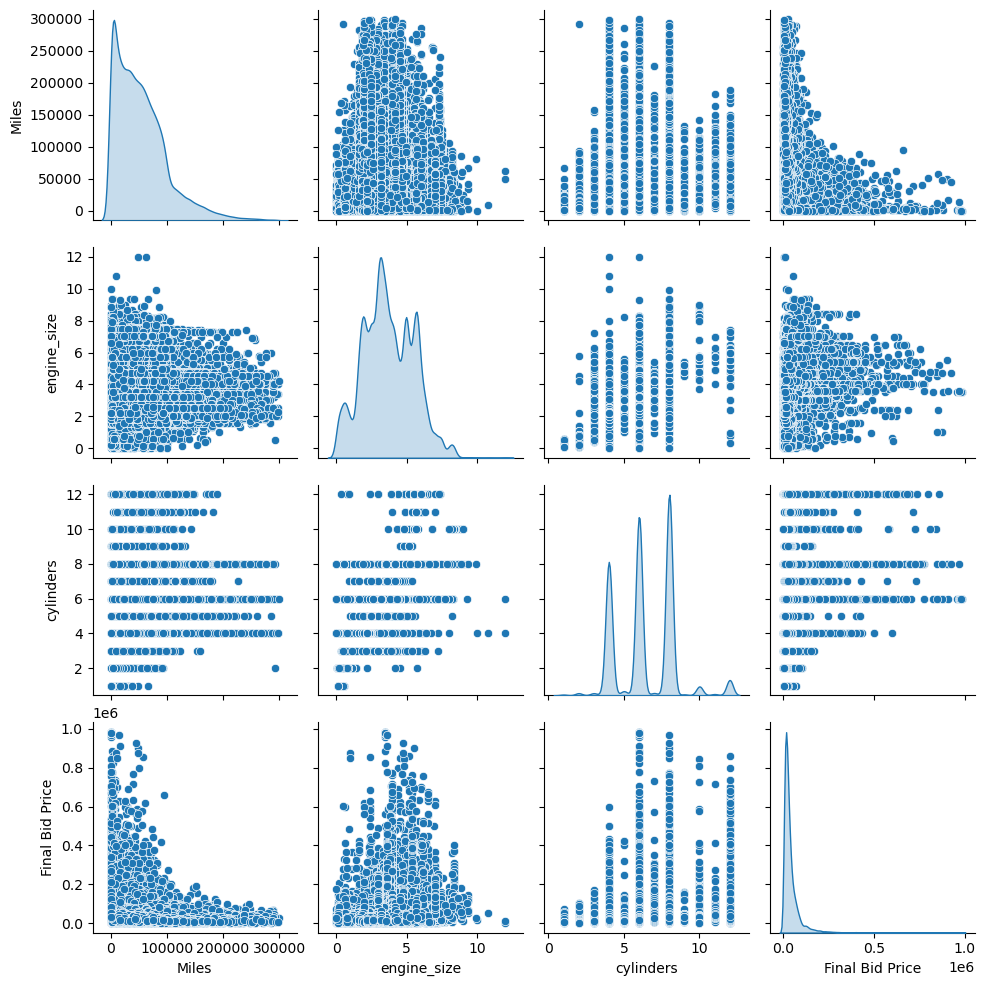

In [22]:
# We have a total of 52 nans, so we drop them
data.dropna(inplace=True)
print(data.isna().sum())

print(data.describe().transpose())

sns.pairplot(data[['Miles', 'engine_size', 'cylinders', 'Final Bid Price']], diag_kind='kde')

In [23]:
# Sanity check
data.head(2)

,Make,Model,Year,Miles,Mileage Notes,Final Bid Price,Details,color,auction_year,engine_size,cylinders
0,acura,integra,1997,52000.0,52k Miles Shown,26500.0,"Chassis: JH4DC2390VS002243 ,52k Miles Shown ,1...",green,2022,1.8,4.0
1,acura,integra,1995,72000.0,72k Miles Shown,7100.0,"Chassis: JH4DB766XSS007382 ,72k Miles Shown ,1...",black,2022,1.8,4.0


<AxesSubplot:>

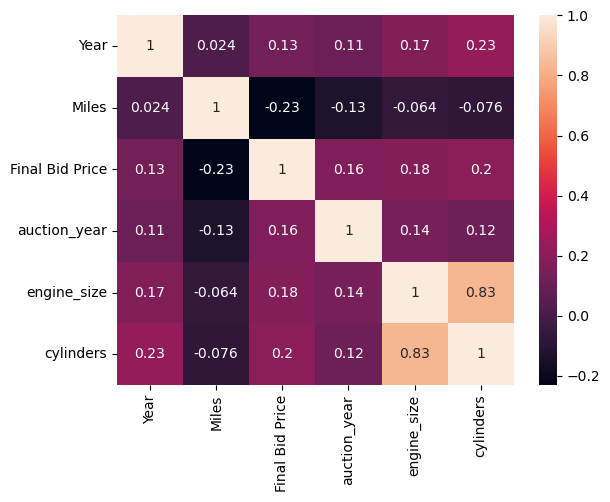

In [24]:
sns.heatmap(data.corr(), annot = True)

## Save Final Data File as .CSV

In [25]:
# Drop unneeded columns and save final .csv file
# data.drop("Details", axis=1, inplace=True)
# data.drop("Mileage Notes", axis=1, inplace=True)
# data.head()
data.to_csv("../data/vehicle_data/final_bat_auction_data.csv", header=True, index=False)